<img src="https://github.com/FarzadNekouee/Heart_Disease_Prediction/blob/master/image.jpg?raw=true" width="1800">

In [1]:
import warnings
warnings.filterwarnings('ignore')# Ignorer les avertissements qui pourraient apparaître

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from scipy.stats import boxcox
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

In [2]:
# Définir la résolution des figures tracées
plt.rcParams['figure.dpi'] = 200

# Configurer les styles de tracé de Seaborn : Définir la couleur de fond et utiliser une grille sombre
sns.set(rc={'axes.facecolor': '#faded9'}, style='darkgrid')

In [3]:
# Lire le jeu de données
df = pd.read_csv('/content/heart.csv')
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [4]:
# Afficher un résumé concis du dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [5]:
#Définir les caractéristiques continues
continuous_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

# Identifier les caractéristiques à convertir en type de données objet
features_to_convert = [feature for feature in df.columns if feature not in continuous_features]

# Convertir les caractéristiques identifiées en type de données objet
df[features_to_convert] = df[features_to_convert].astype('object')

df.dtypes

age           int64
sex          object
cp           object
trestbps      int64
chol          int64
fbs          object
restecg      object
thalach       int64
exang        object
oldpeak     float64
slope        object
ca           object
thal         object
target       object
dtype: object

In [6]:
# Obtenir les statistiques récapitulatives pour les variables numériques
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,303.0,54.366337,9.082101,29.0,47.5,55.0,61.0,77.0
trestbps,303.0,131.623762,17.538143,94.0,120.0,130.0,140.0,200.0
chol,303.0,246.264026,51.830751,126.0,211.0,240.0,274.5,564.0
thalach,303.0,149.646865,22.905161,71.0,133.5,153.0,166.0,202.0
oldpeak,303.0,1.039604,1.161075,0.0,0.0,0.8,1.6,6.2


In [7]:
# Obtenir les statistiques récapitulatives pour les variables catégorielles
df.describe(include='object')

,sex,cp,fbs,restecg,exang,slope,ca,thal,target
count,303,303,303,303,303,303,303,303,303
unique,2,4,2,3,2,3,5,4,2
top,1,0,0,1,0,2,0,2,1
freq,207,143,258,152,204,142,175,166,165


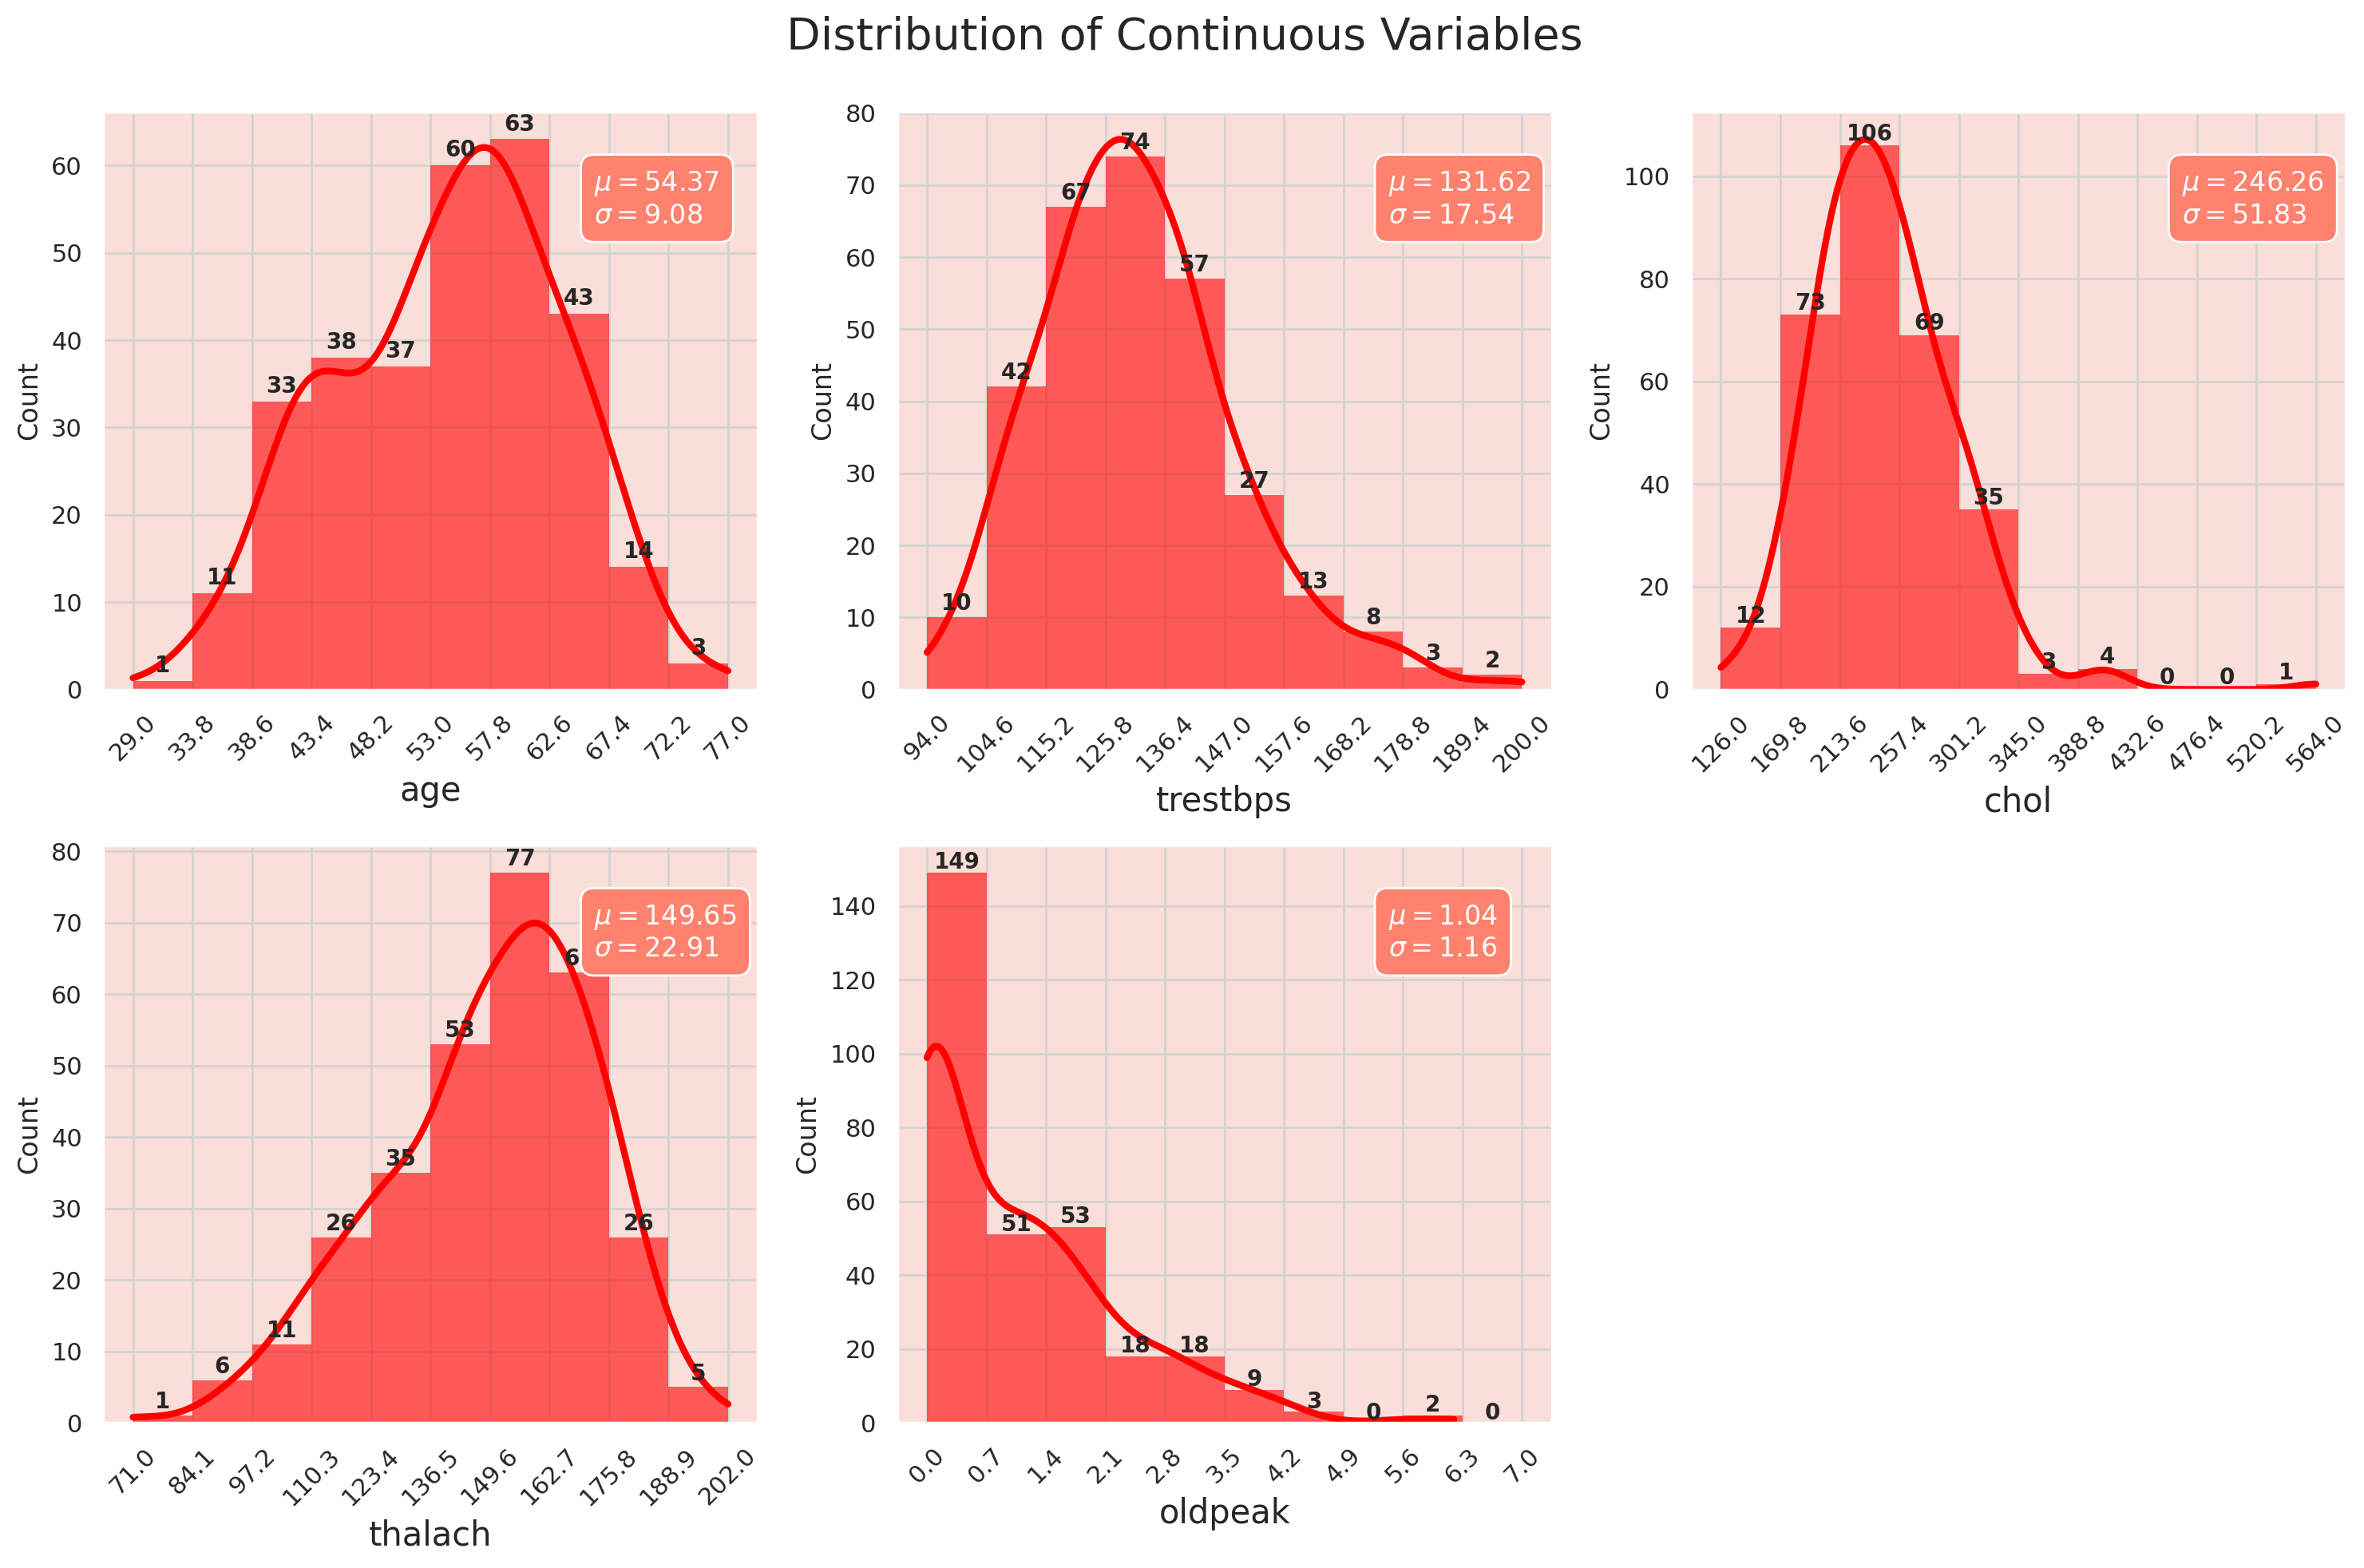

In [8]:
# Filtrer les caractéristiques continues pour l'analyse univariée
df_continuous = df[continuous_features]

# Configurer la disposition des sous-graphiques
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Boucle pour tracer les histogrammes de chaque caractéristique continue
for i, col in enumerate(df_continuous.columns):
    x = i // 3
    y = i % 3
    values, bin_edges = np.histogram(df_continuous[col],
                                     range=(np.floor(df_continuous[col].min()), np.ceil(df_continuous[col].max())))

    graph = sns.histplot(data=df_continuous, x=col, bins=bin_edges, kde=True, ax=ax[x, y],
                         edgecolor='none', color='red', alpha=0.6, line_kws={'lw': 3})
    ax[x, y].set_xlabel(col, fontsize=15)
    ax[x, y].set_ylabel('Count', fontsize=12)
    ax[x, y].set_xticks(np.round(bin_edges, 1))
    ax[x, y].set_xticklabels(ax[x, y].get_xticks(), rotation=45)
    ax[x, y].grid(color='lightgrey')

    for j, p in enumerate(graph.patches):
        ax[x, y].annotate('{}'.format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height() + 1),
                          ha='center', fontsize=10, fontweight="bold")

    textstr = '\n'.join((
        r'$\mu=%.2f$' % df_continuous[col].mean(),
        r'$\sigma=%.2f$' % df_continuous[col].std()
    ))
    ax[x, y].text(0.75, 0.9, textstr, transform=ax[x, y].transAxes, fontsize=12, verticalalignment='top',
                  color='white', bbox=dict(boxstyle='round', facecolor='#ff826e', edgecolor='white', pad=0.5))

ax[1,2].axis('off')
plt.suptitle('Distribution of Continuous Variables', fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

# ***Inférences :***
**Âge (age) :** La distribution est quelque peu uniforme, mais il y a un pic autour de la fin de la cinquantaine. L'âge moyen est d'environ 54,37 ans avec un écart-type de 9,08 ans.

**Tension artérielle au repos (trestbps) : **La tension artérielle au repos pour la plupart des individus est concentrée autour de 120-140 mm Hg, avec une moyenne d'environ 131,62 mm Hg et un écart-type de 17,54 mm Hg.

**Cholestérol sérique (chol) :** La plupart des individus ont des niveaux de cholestérol entre 200 et 300 mg/dl. Le niveau moyen de cholestérol est d'environ 246,26 mg/dl avec un écart-type de 51,83 mg/dl.

**Fréquence cardiaque maximale atteinte (thalach) :** La majorité des individus atteignent une fréquence cardiaque entre 140 et 170 bpm lors d'un test d'effort. La fréquence cardiaque moyenne atteinte est d'environ 149,65 bpm avec un écart-type de 22,91 bpm.

**Dépression ST induite par l'exercice (oldpeak) :** La plupart des valeurs sont concentrées autour de 0, ce qui indique que de nombreux individus n'ont pas ressenti de dépression ST significative pendant l'exercice. La valeur moyenne de la dépression ST est de 1,04 avec un écart-type de 1,16.
Après avoir examiné les histogrammes des caractéristiques continues et les avoir croisés avec les descriptions des caractéristiques fournies, tout semble cohérent et dans les plages attendues. Il ne semble pas y avoir de bruit notable ou de valeurs implausibles parmi les variables continues.

In [9]:
# Filtrer les caractéristiques catégorielles pour l'analyse univariée
categorical_features = df.columns.difference(continuous_features)
df_categorical = df[categorical_features]

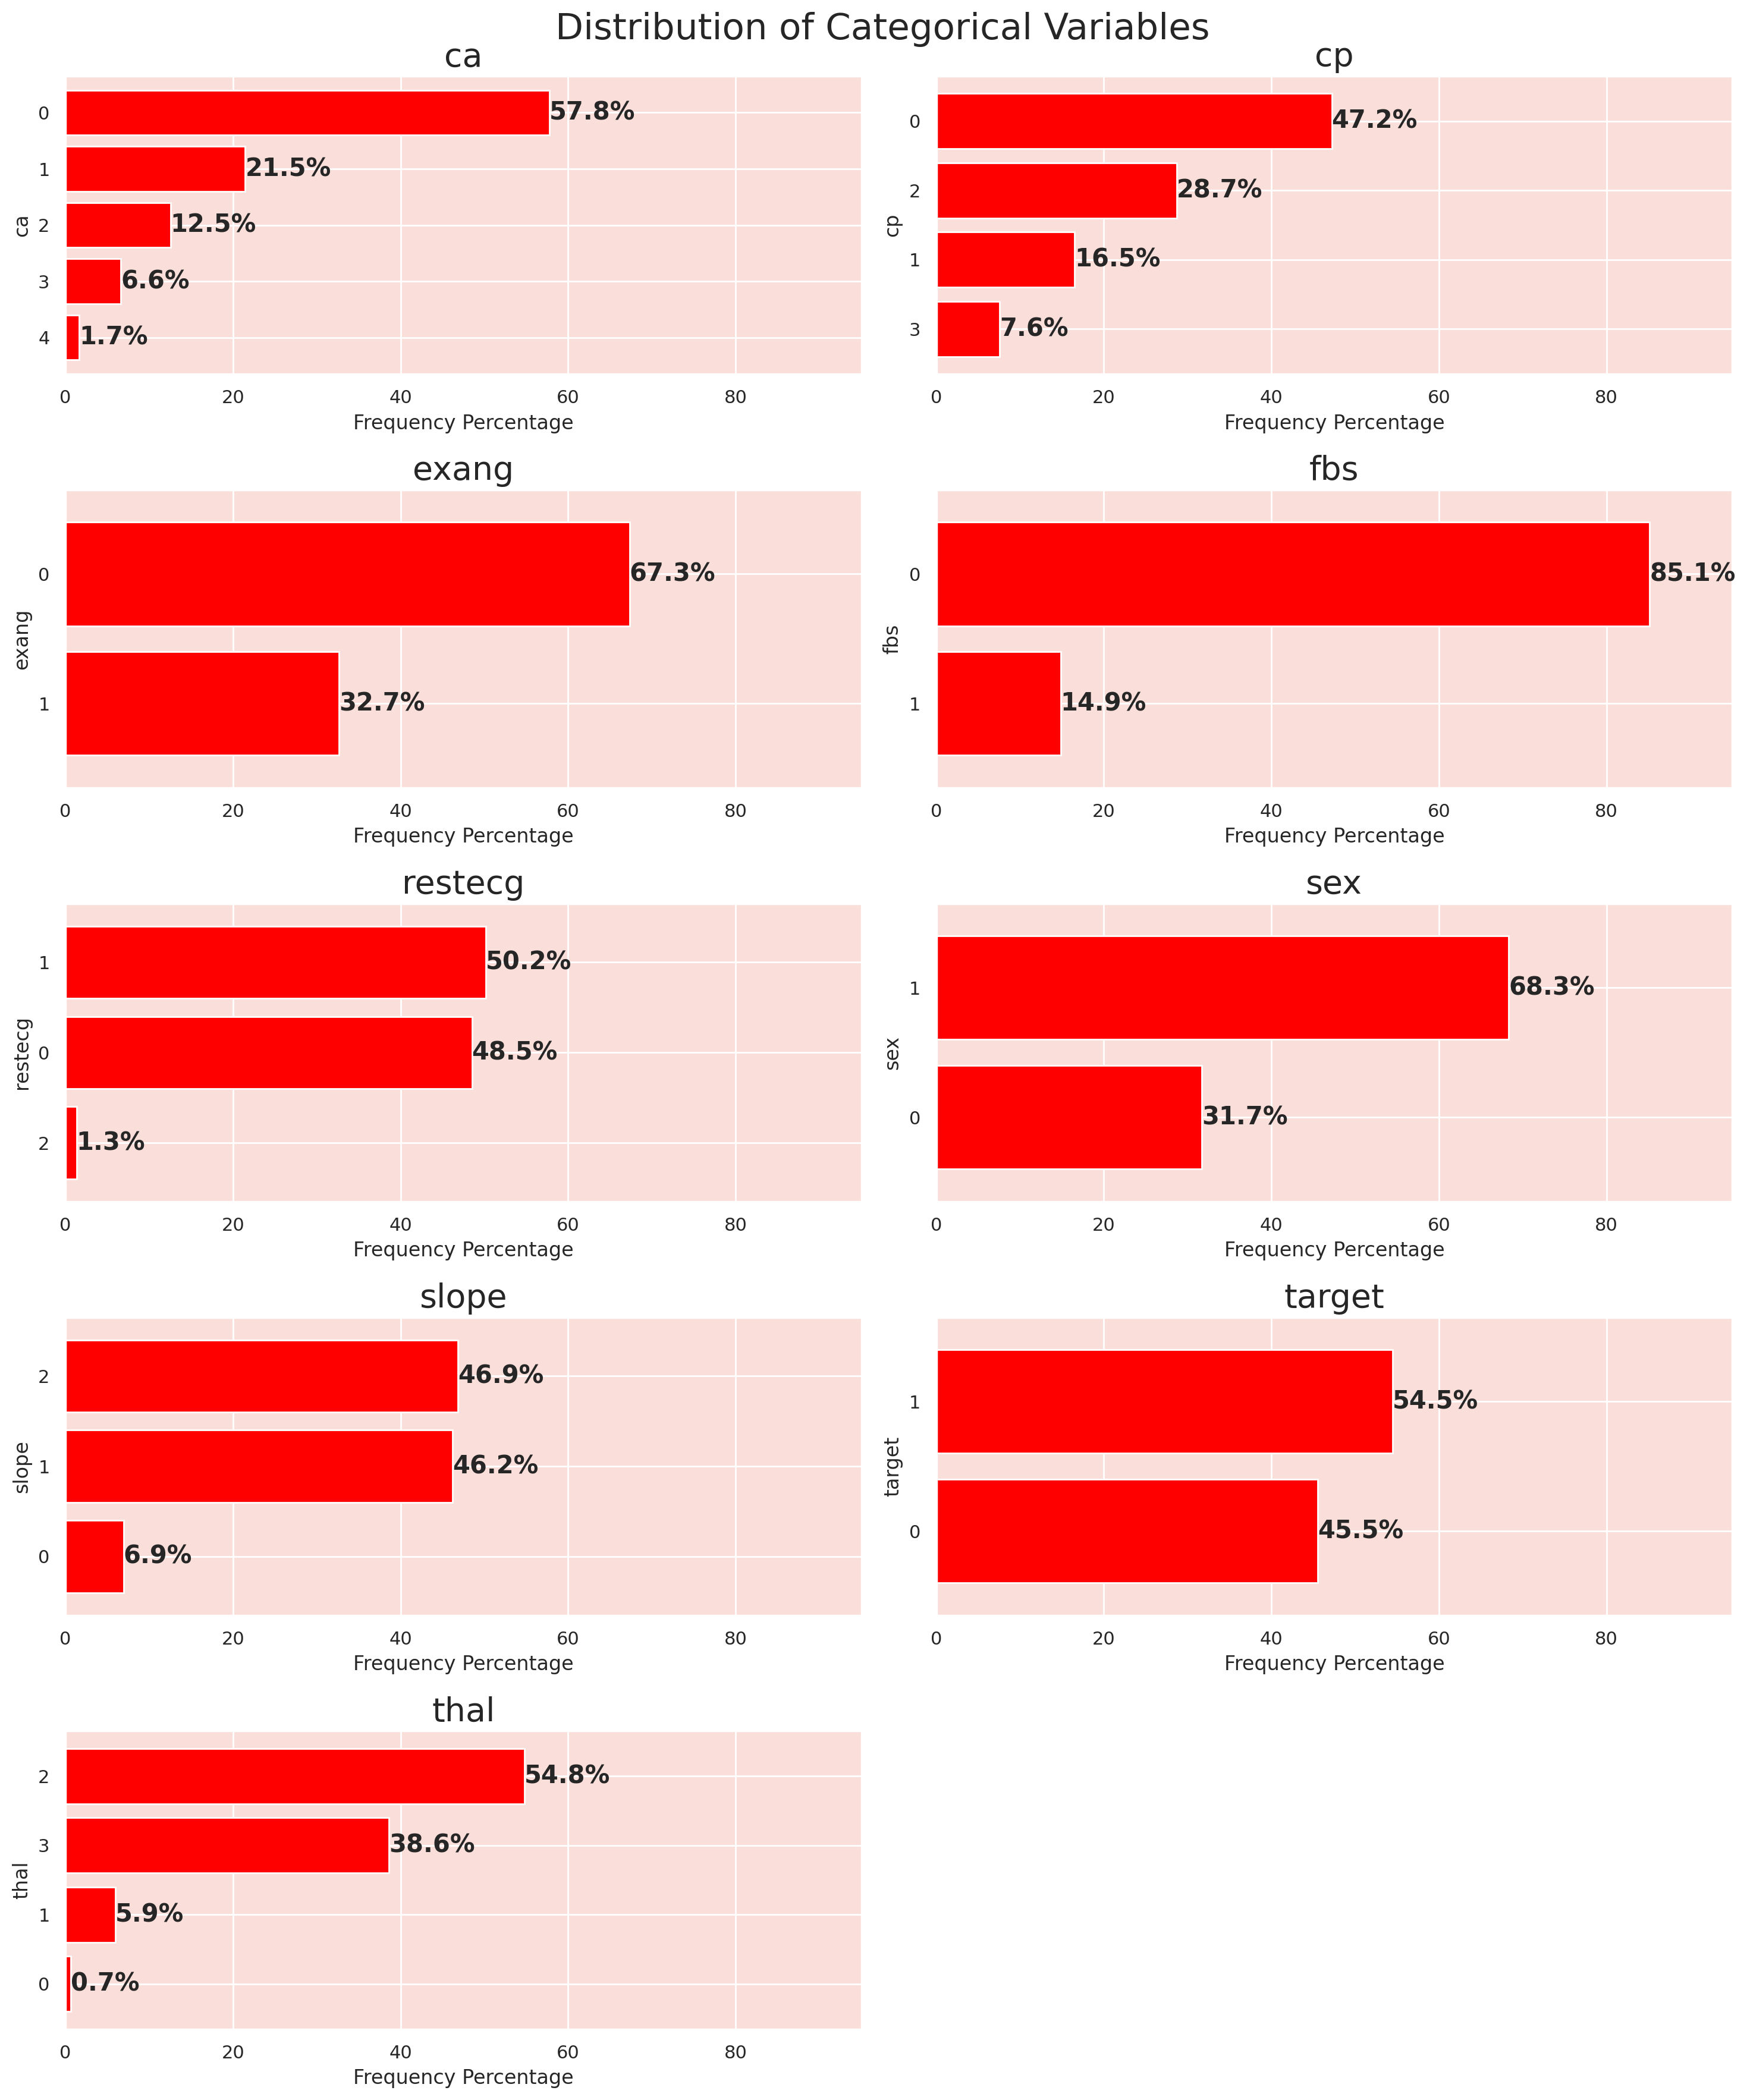

In [10]:
# Configurer la disposition des sous-graphiques pour une disposition 4x2
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(15, 18))

# Boucle pour tracer les diagrammes à barres de chaque caractéristique catégorielle dans la disposition 4x2
for i, col in enumerate(categorical_features):
    row = i // 2
    col_idx = i % 2

    # Calculer les pourcentages de fréquence
    value_counts = df[col].value_counts(normalize=True).mul(100).sort_values()

    # Tracer le diagramme à barres
    value_counts.plot(kind='barh', ax=ax[row, col_idx], width=0.8, color='red')

    # Ajouter les pourcentages de fréquence aux barres
    for index, value in enumerate(value_counts):
        ax[row, col_idx].text(value, index, str(round(value, 1)) + '%', fontsize=15, weight='bold', va='center')

    ax[row, col_idx].set_xlim([0, 95])
    ax[row, col_idx].set_xlabel('Frequency Percentage', fontsize=12)
    ax[row, col_idx].set_title(f'{col}', fontsize=20)

ax[4,1].axis('off')
plt.suptitle('Distribution of Categorical Variables', fontsize=22)
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

# ***Inférences :***
**Genre (sex) :** Le jeu de données est principalement féminin, constituant une majorité significative.

**Type de douleur thoracique (cp) :** Le jeu de données montre des types de douleur thoracique variés parmi les patients. Le type 0 (Angine typique) semble être le plus répandu, mais une distribution exacte entre les types peut être déduite des diagrammes en barres.

**Glycémie à jeun (fbs) :**Une majorité significative des patients ont leur taux de glycémie à jeun inférieur à 120 mg/dl, ce qui indique que l'hyperglycémie n'est pas une condition courante dans ce jeu de données.

**Résultats électrocardiographiques au repos (restecg) :** Les résultats montrent des issues électrocardiographiques au repos variées, certains types étant plus courants que d'autres. La distribution exacte peut être évaluée à partir des graphiques.

**Angine induite par l'exercice (exang) :** Une majorité des patients ne ressentent pas d'angine induite par l'exercice, suggérant que cela pourrait ne pas être un symptôme courant parmi les patients de ce jeu de données.
Pente du segment ST de l'exercice de pointe (slope) : Le jeu de données montre différentes pentes du segment ST de l'exercice de pointe. Un type spécifique pourrait être plus courant, et sa distribution peut être déduite des diagrammes en barres.

**Nombre de gros vaisseaux colorés par fluoroscopie (ca) :** La plupart des patients ont moins de gros vaisseaux colorés par fluoroscopie, avec '0' étant le plus fréquent.

**Résultat du test de stress au thallium (thal) :** Le jeu de données affiche une variété de résultats de test de stress au thallium. Un type particulier semble être plus répandu, mais la distribution exacte peut être vue dans les graphiques.

**Présence de maladie cardiaque (target) : **Le jeu de données est presque équilibré en termes de présence de maladie cardiaque, avec environ 54,5 % l'ayant et 45,5 % ne l'ayant pas.

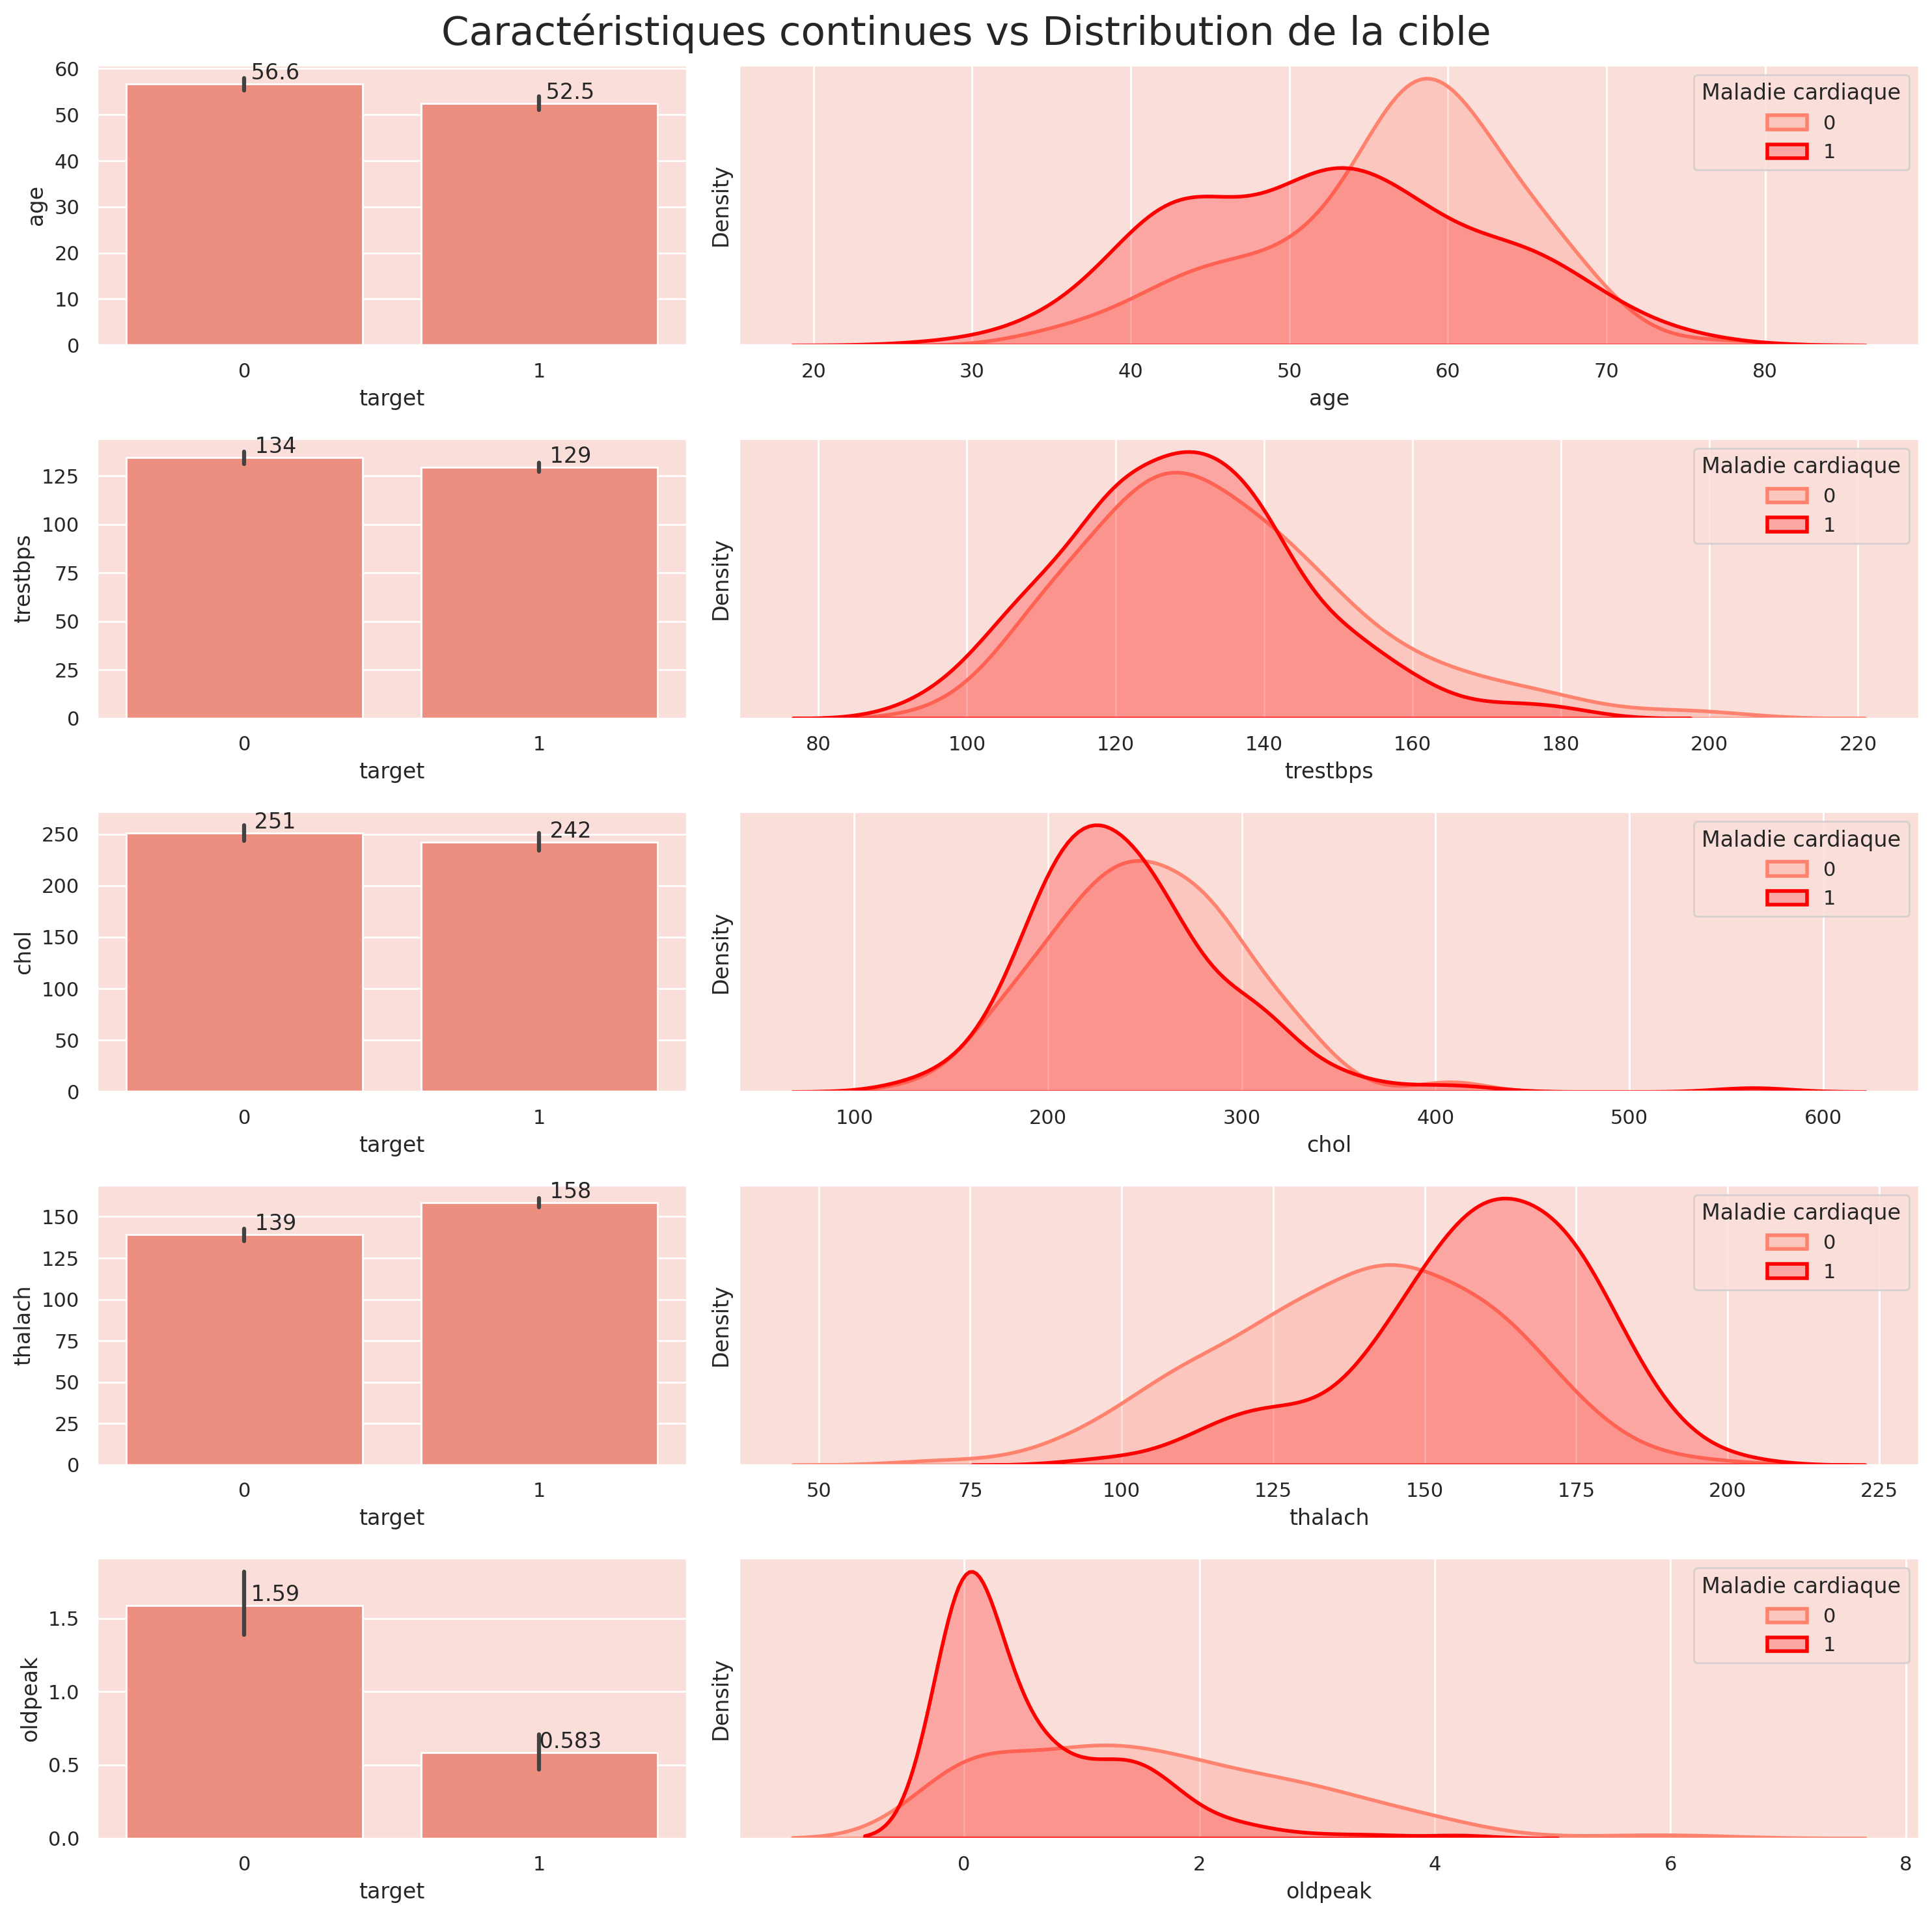

In [11]:
# Définir la palette de couleurs
sns.set_palette(['#ff826e', 'red'])

# Créer les sous-graphiques
fig, ax = plt.subplots(len(continuous_features), 2, figsize=(15,15), gridspec_kw={'width_ratios': [1, 2]})

# Parcourir chaque caractéristique continue pour créer les diagrammes en barres et les graphiques de densité de probabilité (KDE)
for i, col in enumerate(continuous_features):
    # Diagramme en barres montrant la valeur moyenne de la caractéristique pour chaque catégorie cible
    graph = sns.barplot(data=df, x="target", y=col, ax=ax[i,0])

    # Graphique de densité de probabilité (KDE) montrant la distribution de la caractéristique pour chaque catégorie cible
    sns.kdeplot(data=df[df["target"]==0], x=col, fill=True, linewidth=2, ax=ax[i,1], label='0')
    sns.kdeplot(data=df[df["target"]==1], x=col, fill=True, linewidth=2, ax=ax[i,1], label='1')
    ax[i,1].set_yticks([])
    ax[i,1].legend(title='Maladie cardiaque', loc='upper right')

    # Ajouter les valeurs moyennes au diagramme en barres
    for cont in graph.containers:
        graph.bar_label(cont, fmt='         %.3g')

# Définir le titre pour l'ensemble de la figure
plt.suptitle('Caractéristiques continues vs Distribution de la cible', fontsize=22)
plt.tight_layout()
plt.show()


# ***Inférences :***
**Âge (age) :** Les distributions montrent un léger décalage avec les patients atteints de maladie cardiaque étant un peu plus jeunes en moyenne que ceux sans maladie cardiaque. L'âge moyen des patients sans maladie cardiaque est plus élevé.

**Tension artérielle au repos (trestbps) :** Les deux catégories affichent des distributions qui se chevauchent dans le graphique KDE, avec des valeurs moyennes presque identiques, indiquant un pouvoir de différenciation limité pour cette caractéristique.

**Cholestérol sérique (chol) :** Les distributions des niveaux de cholestérol pour les deux catégories sont assez proches, mais le niveau moyen de cholestérol pour les patients atteints de maladie cardiaque est légèrement plus bas.

**Fréquence cardiaque maximale atteinte (thalach) :** Il y a une différence notable dans les distributions. Les patients atteints de maladie cardiaque ont tendance à atteindre une fréquence cardiaque maximale plus élevée lors des tests de stress par rapport à ceux sans maladie.

**Dépression ST (oldpeak) :** La dépression ST induite par l'exercice par rapport au repos est notablement plus faible pour les patients atteints de maladie cardiaque. Leur distribution culmine près de zéro, tandis que la catégorie sans maladie présente une dispersion plus large.


Sur la base de la différence visuelle dans les distributions et les valeurs moyennes, la Fréquence cardiaque maximale (thalach) semble avoir le plus d'impact sur le statut de la maladie cardiaque, suivi par la Dépression ST (oldpeak) et l'Âge (age).

In [12]:
# Supprimer 'target' des categorical_features
categorical_features = [feature for feature in categorical_features if feature != 'target']


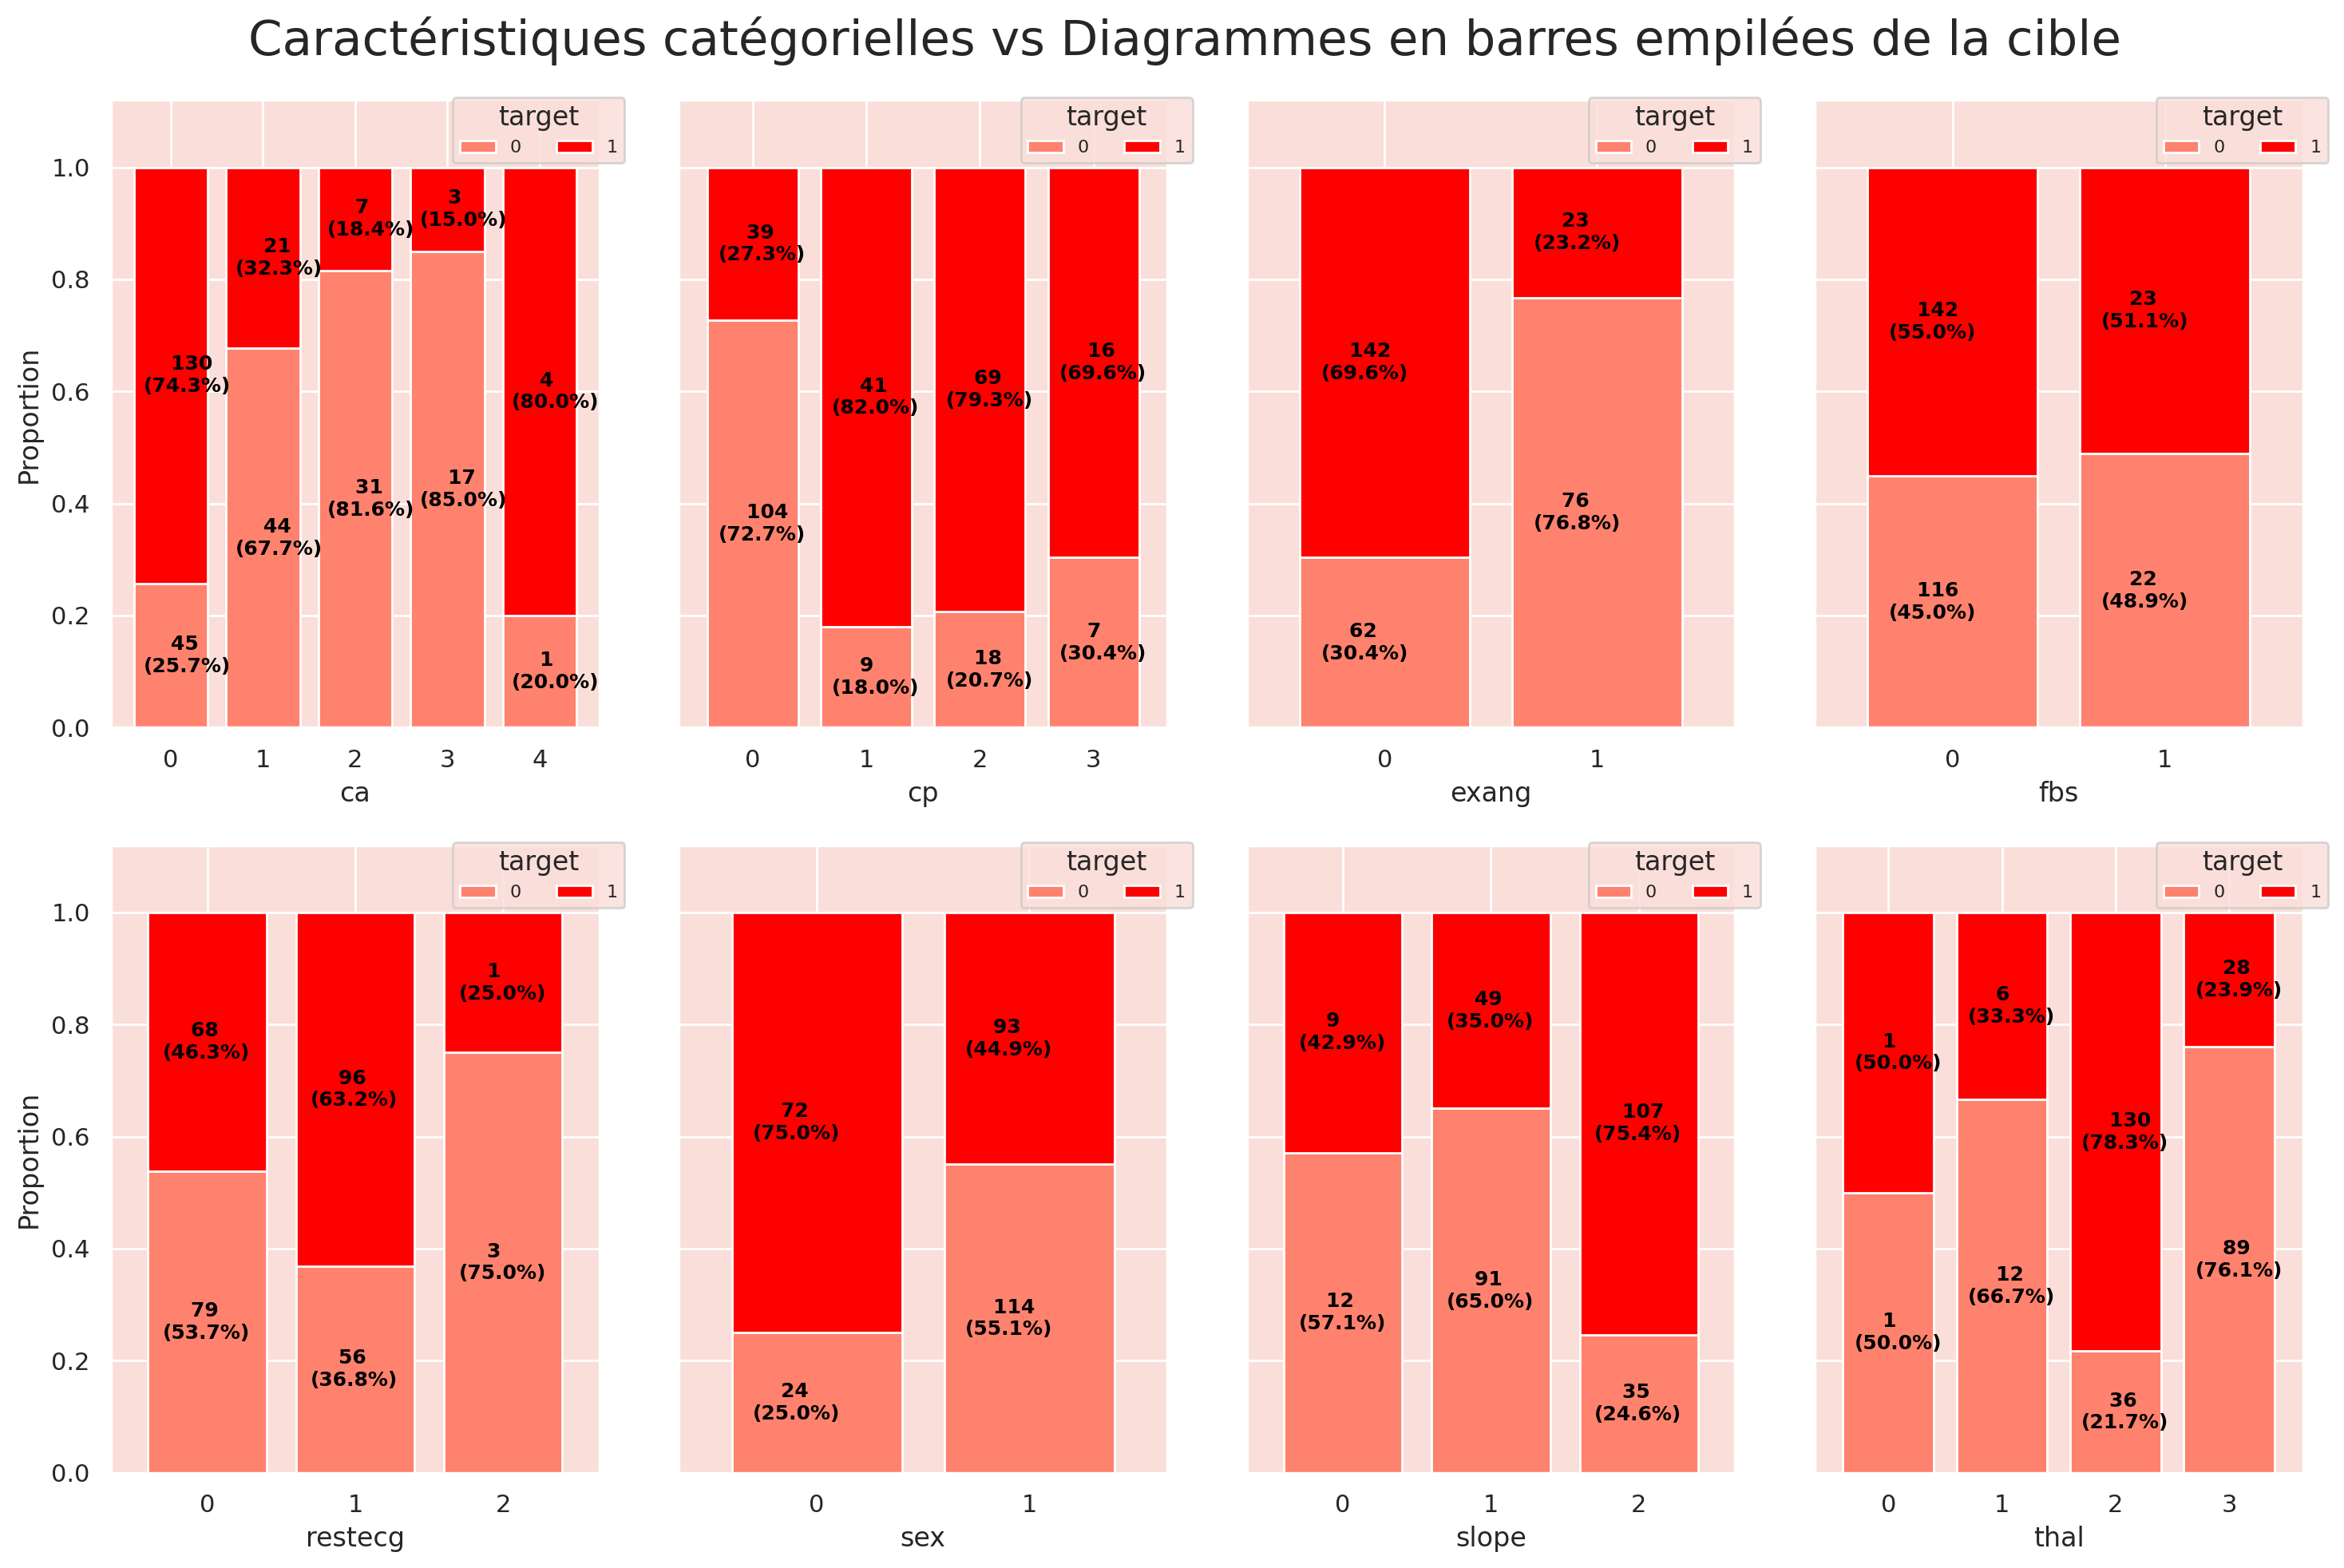

In [13]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15,10))

for i,col in enumerate(categorical_features):

    # Créer un tableau croisé montrant la proportion des prêts achetés et non achetés pour chaque catégorie de la caractéristique
    cross_tab = pd.crosstab(index=df[col], columns=df['target'])

    # En utilisant l'argument normalize=True, nous obtenons la proportion par index des données
    cross_tab_prop = pd.crosstab(index=df[col], columns=df['target'], normalize='index')

    # Définir la colormap
    cmp = ListedColormap(['#ff826e', 'red'])

    # Tracer les diagrammes en barres empilées
    x, y = i//4, i%4
    cross_tab_prop.plot(kind='bar', ax=ax[x,y], stacked=True, width=0.8, colormap=cmp,
                        legend=False, ylabel='Proportion', sharey=True)

    # Ajouter les proportions et les comptes des barres individuelles à notre graphique
    for idx, val in enumerate([*cross_tab.index.values]):
        for (proportion, count, y_location) in zip(cross_tab_prop.loc[val],cross_tab.loc[val],cross_tab_prop.loc[val].cumsum()):
            ax[x,y].text(x=idx-0.3, y=(y_location-proportion)+(proportion/2)-0.03,
                         s = f'    {count}\n({np.round(proportion * 100, 1)}%)',
                         color = "black", fontsize=9, fontweight="bold")

    # Ajouter la légende
    ax[x,y].legend(title='target', loc=(0.7,0.9), fontsize=8, ncol=2)
    # Définir la limite y
    ax[x,y].set_ylim([0,1.12])
    # Rotation des xticks
    ax[x,y].set_xticklabels(ax[x,y].get_xticklabels(), rotation=0)


plt.suptitle('Caractéristiques catégorielles vs Diagrammes en barres empilées de la cible', fontsize=22)
plt.tight_layout()
plt.show()


# ***Inférences :***
**Nombre de gros vaisseaux (ca) :**La majorité des patients atteints de maladie cardiaque ont moins de gros vaisseaux colorés par fluoroscopie. À mesure que le nombre de vaisseaux colorés augmente, la proportion de patients atteints de maladie cardiaque tend à diminuer. En particulier, les patients avec 0 vaisseaux colorés ont une proportion plus élevée de présence de maladie cardiaque.

**Type de douleur thoracique (cp) :** Différents types de douleur thoracique présentent des proportions variées de maladie cardiaque. Notamment, les types 1, 2 et 3 ont une proportion plus élevée de présence de maladie cardiaque par rapport au type 0. Cela suggère que le type de douleur thoracique peut avoir une influence dans la prédiction de la maladie.

**Angine induite par l'exercice (exang) :** Les patients qui n'ont pas ressenti d'angine induite par l'exercice (0) montrent une proportion plus élevée de présence de maladie cardiaque par rapport à ceux qui l'ont ressenti (1). Cette caractéristique semble avoir un impact significatif sur la cible.

**Glycémie à jeun (fbs) :** La distribution entre ceux avec une glycémie à jeun > 120 mg/dl (1) et ceux sans (0) est relativement similaire, suggérant que la glycémie à jeun pourrait avoir un impact limité sur la prédiction de la maladie cardiaque.

**Résultats électrocardiographiques au repos (restecg) :** Le type 1 affiche une proportion plus élevée de présence de maladie cardiaque, indiquant que cette caractéristique pourrait avoir une certaine influence sur le résultat.

**Genre (sex) :** Les femmes (1) présentent une proportion plus faible de présence de maladie cardiaque par rapport aux hommes (0). Cela indique que le sexe est un facteur influent dans la prédiction de la maladie cardiaque.

**Pente du segment ST de l'exercice de pointe (slope) :** La pente de type 2 a une proportion notablement plus élevée de présence de maladie cardiaque, indiquant son potentiel en tant que prédicteur significatif.

**Résultat du test de stress au thallium (thal) :** La catégorie de défaut réversible (2) a une proportion plus élevée de présence de maladie cardiaque par rapport aux autres catégories, soulignant son importance dans la prédiction.


En résumé, basé sur la représentation visuelle :

Impact plus élevé sur la cible : ca, cp, exang, sex, slope et thal

Impact modéré sur la cible : restecg

Impact plus faible sur la cible : fbs

# ***Data preprocessing***

In [14]:
# Vérifier les valeurs manquantes dans l'ensemble de données
df.isnull().sum().sum()


0

Suite à notre inspection ci-dessus, il est évident qu'il n'y a pas de valeurs manquantes dans notre ensemble de données. C'est idéal car cela signifie que nous n'avons pas à prendre de décisions concernant l'imputation ou la suppression, ce qui peut introduire un biais ou réduire notre taille d'ensemble de données déjà limitée.

Je vais vérifier la présence de valeurs aberrantes en utilisant la méthode de l'écart interquartile (IQR) pour les caractéristiques continues.

In [15]:
continuous_features

['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

In [16]:
Q1 = df[continuous_features].quantile(0.25)
Q3 = df[continuous_features].quantile(0.75)
IQR = Q3 - Q1
outliers_count_specified = ((df[continuous_features] < (Q1 - 1.5 * IQR)) | (df[continuous_features] > (Q3 + 1.5 * IQR))).sum()

outliers_count_specified

age         0
trestbps    9
chol        5
thalach     1
oldpeak     5
dtype: int64

Après avoir identifié les valeurs aberrantes pour les caractéristiques continues spécifiées, nous avons trouvé ce qui suit :

trestbps : 9 valeurs aberrantes

chol : 5 valeurs aberrantes

thalach : 1 valeur aberrante

oldpeak : 5 valeurs aberrantes

âge : Aucune valeur aberrante

Sensibilité aux valeurs aberrantes :

**Arbres de Décision (DT) et Forêts Aléatoires (RF) :** Ces algorithmes basés sur des arbres sont généralement robustes aux valeurs aberrantes. Ils effectuent des divisions basées sur les valeurs des caractéristiques, et les valeurs aberrantes finissent souvent dans les nœuds feuilles, ayant un impact minimal sur le processus de prise de décision global.

**K-Nearest Neighbors (KNN) :** KNN est sensible aux valeurs aberrantes car il repose sur les distances entre les points de données pour faire des prédictions. Les valeurs aberrantes peuvent fausser ces distances.

# **Approches pour le traitement des valeurs aberrantes :**
**Suppression des valeurs aberrantes :** Éliminer directement les points de données qui se situent en dehors d'une plage définie, généralement basée sur une méthode comme l'écart interquartile (IQR).

**Plafonnement des valeurs aberrantes :** Au lieu de les supprimer, nous pouvons limiter les valeurs aberrantes à un certain seuil, tel que le 1er ou le 99e percentile.

**Transformations :** Appliquer des transformations comme le logarithme ou le Box-Cox peut réduire l'impact des valeurs aberrantes et rendre les données plus semblables à une distribution gaussienne.

**Mise à l'échelle robuste :** Des techniques comme RobustScaler dans Scikit-learn peuvent être utilisées, qui mettent à l'échelle les caractéristiques en utilisant des statistiques robustes aux valeurs aberrantes.

# **Décision sur l'encodage one-hot :**

**Variables nominales :** Ce sont des variables sans ordre inhérent. Elles doivent être encodées en one-hot car les utiliser comme des nombres pourrait introduire un ordre non intentionnel dans le modèle.

**Variables ordinales :** Ces variables ont un ordre inhérent. Elles n'ont pas nécessairement besoin d'être encodées en one-hot car leur ordre peut fournir des informations significatives au modèle.

In [17]:
# Implémenter le codage one-hot sur les caractéristiques catégorielles spécifiées
df_encoded = pd.get_dummies(df, columns=['cp', 'restecg', 'thal'], drop_first=True)

# Convertir le reste des variables catégorielles qui ne nécessitent pas de codage one-hot en type de données entier
features_to_convert = ['sex', 'fbs', 'exang', 'slope', 'ca', 'target']
for feature in features_to_convert:
    df_encoded[feature] = df_encoded[feature].astype(int)

df_encoded.dtypes


age            int64
sex            int64
trestbps       int64
chol           int64
fbs            int64
thalach        int64
exang          int64
oldpeak      float64
slope          int64
ca             int64
target         int64
cp_1            bool
cp_2            bool
cp_3            bool
restecg_1       bool
restecg_2       bool
thal_1          bool
thal_2          bool
thal_3          bool
dtype: object

In [18]:
# Afficher le DataFrame résultant après le codage one-hot
df_encoded.head()


,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,slope,ca,target,cp_1,cp_2,cp_3,restecg_1,restecg_2,thal_1,thal_2,thal_3
0,63,1,145,233,1,150,0,2.3,0,0,1,False,False,True,False,False,True,False,False
1,37,1,130,250,0,187,0,3.5,0,0,1,False,True,False,True,False,False,True,False
2,41,0,130,204,0,172,0,1.4,2,0,1,True,False,False,False,False,False,True,False
3,56,1,120,236,0,178,0,0.8,2,0,1,True,False,False,True,False,False,True,False
4,57,0,120,354,0,163,1,0.6,2,0,1,False,False,False,True,False,False,True,False


La transformation **Box-Cox** est une méthode puissante pour stabiliser la variance et rendre les données plus semblables à une distribution normale. Elle est particulièrement utile lorsque vous n'êtes pas sûr de la nature exacte de la distribution avec laquelle vous travaillez, car elle peut s'adapter à la meilleure transformation de puissance. Cependant, la transformation Box-Cox ne fonctionne que pour des données positives, il faut donc être prudent lors de son application aux caractéristiques contenant des zéros ou des valeurs négatives.

**Transformation des caractéristiques asymétriques et préoccupations concernant les fuites de données :**

Lors de la prétraitement des données, notamment l'application de transformations comme la transformation Box-Cox, il est essentiel de se méfier des fuites de données. Les fuites de données font référence à une erreur dans le prétraitement des données dans laquelle des informations provenant de l'extérieur de l'ensemble de données d'entraînement sont utilisées pour transformer ou entraîner le modèle. Cela peut conduire à des mesures de performance trop optimistes.

Pour éviter les fuites de données et garantir que notre modèle généralise bien aux données non vues :

**1. Séparation des données :** Nous allons d'abord diviser notre ensemble de données en un ensemble d'entraînement et un ensemble de test. Cela garantit que nous disposons d'un ensemble de données distinct pour évaluer les performances de notre modèle, non modifié lors des phases d'entraînement et de prétraitement.

**2. Transformation Box-Cox :** Nous examinerons la distribution des caractéristiques continues dans l'ensemble d'entraînement. Si elles semblent asymétriques, nous appliquerons la transformation Box-Cox pour stabiliser la variance et rendre les données plus semblables à une distribution normale. Importamment, nous déterminerons les paramètres de transformation Box-Cox uniquement sur la base des données d'entraînement.

**3. Application des transformations aux données de test :** Une fois que nos paramètres de transformation sont déterminés à partir de l'ensemble d'entraînement, nous utiliserons ces paramètres exacts pour transformer notre ensemble de validation/test. Cette approche garantit qu'aucune information de l'ensemble de validation/test ne fuit dans notre processus d'entraînement.

**4. Ajustement des hyperparamètres et validation croisée :** Étant donné la taille de notre ensemble de données, pour tirer le meilleur parti des données disponibles lors de la phase d'entraînement du modèle, nous utiliserons la validation croisée sur l'ensemble d'entraînement pour l'ajustement des hyperparamètres. Cela nous permet d'avoir une meilleure idée de la façon dont notre modèle pourrait se comporter sur des données non vues, sans utiliser réellement l'ensemble de test. L'ensemble de test reste intact pendant cette phase et n'est utilisé que pour évaluer les performances du modèle final.

En suivant cette approche structurée, nous assurons un processus d'entraînement rigoureux, minimisons le risque de fuites de données et nous nous préparons à obtenir une mesure réaliste des performances de notre modèle sur des données non vues.

In [19]:
# Définir les caractéristiques (X) et les étiquettes de sortie (y)
X = df_encoded.drop('target', axis=1)
y = df_encoded['target']


In [20]:
# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)


In [21]:
continuous_features

['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

La transformation Box-Cox nécessite que toutes les données soient strictement positives. Pour transformer la caractéristique oldpeak en utilisant Box-Cox, nous pouvons ajouter une petite constante (par exemple, 0.001) pour garantir que toutes les valeurs sont positives :

In [22]:
# Ajout d'une petite constante à 'oldpeak' pour rendre toutes les valeurs positives
X_train['oldpeak'] = X_train['oldpeak'] + 0.001
X_test['oldpeak'] = X_test['oldpeak'] + 0.001


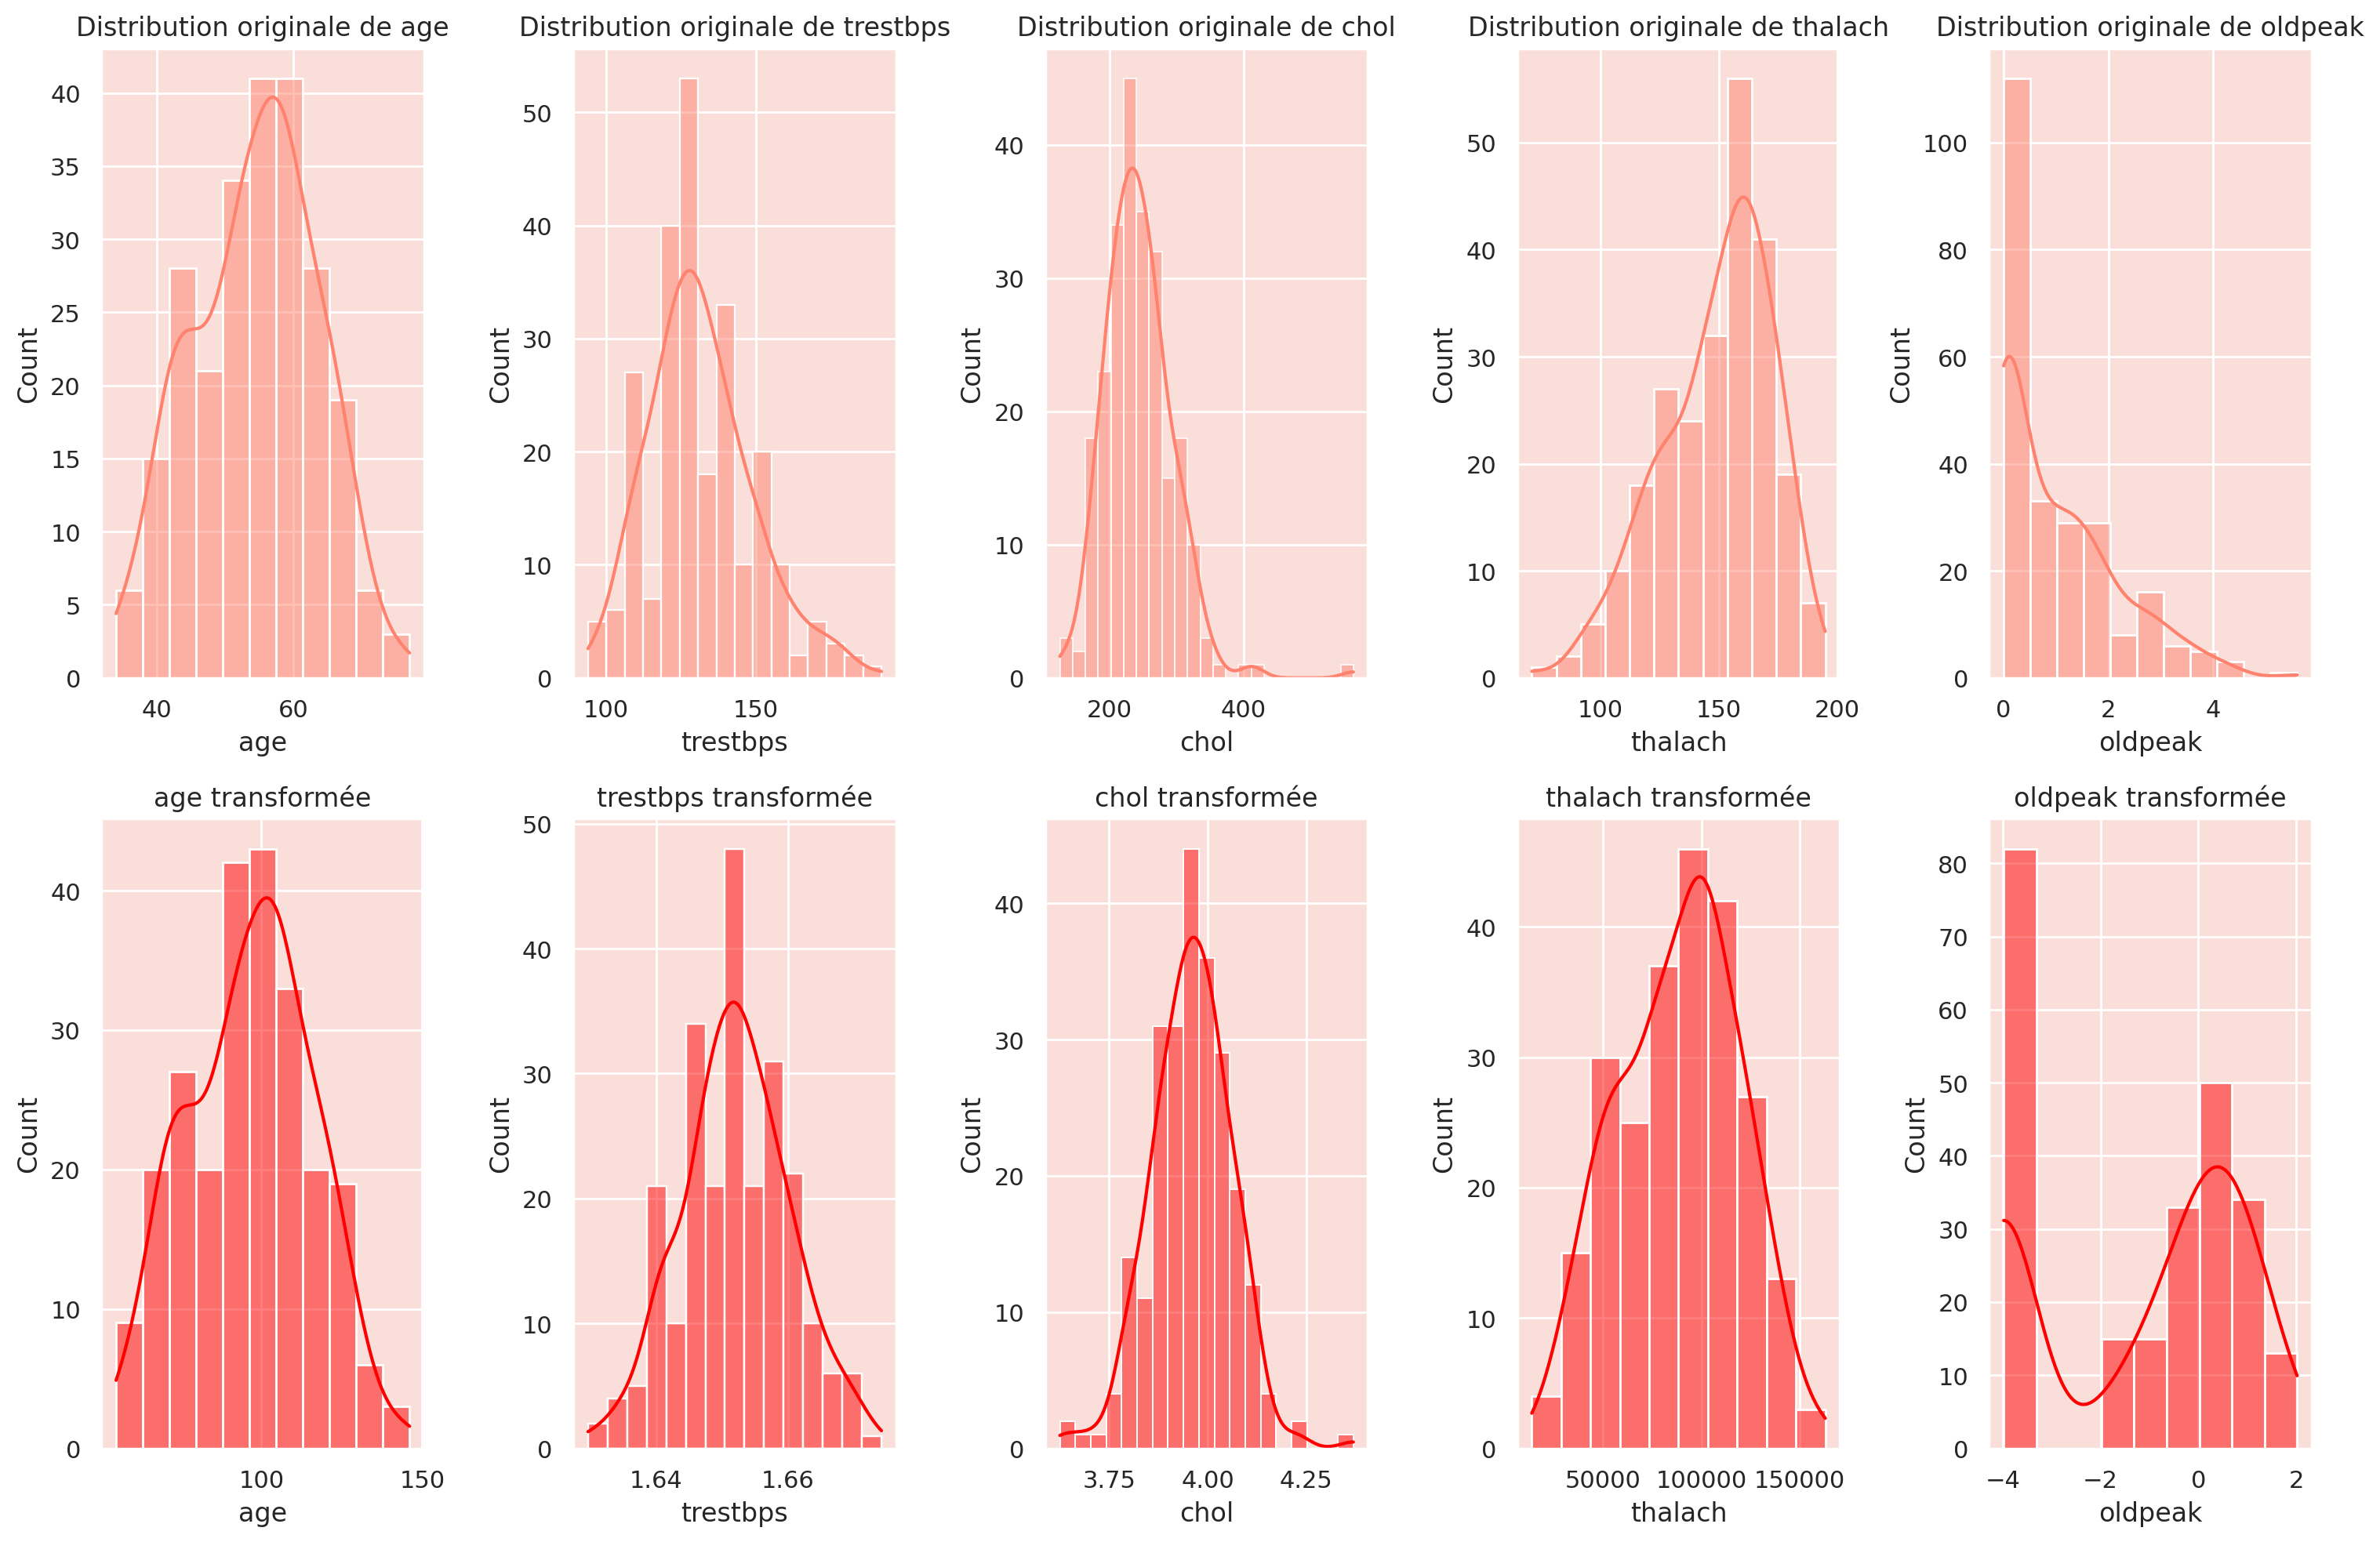

In [23]:
# Vérification de la distribution des caractéristiques continues
fig, ax = plt.subplots(2, 5, figsize=(15,10))

# Distributions originales
for i, col in enumerate(continuous_features):
    sns.histplot(X_train[col], kde=True, ax=ax[0,i], color='#ff826e').set_title(f'Distribution originale de {col}')


# Application de la transformation Box-Cox
# Dictionnaire pour stocker les valeurs lambda pour chaque caractéristique
lambdas = {}

for i, col in enumerate(continuous_features):
    # Appliquer uniquement la transformation Box-Cox pour les valeurs positives
    if X_train[col].min() > 0:
        X_train[col], lambdas[col] = boxcox(X_train[col])
        # Appliquer le même lambda aux données de test
        X_test[col] = boxcox(X_test[col], lmbda=lambdas[col])
        sns.histplot(X_train[col], kde=True, ax=ax[1,i], color='red').set_title(f'{col} transformée')
    else:
        sns.histplot(X_train[col], kde=True, ax=ax[1,i], color='green').set_title(f'{col} (Non transformée)')

fig.tight_layout()
plt.show()


# ***Inférence :***
**1- âge :** La transformation a rendu la distribution de l'âge plus symétrique, la rapprochant d'une distribution normale.

**2- Trestbps :** La distribution de trestbps après transformation semble plus proche d'une distribution normale, avec une réduction de l'asymétrie.

**3- Chol :** Après application de la transformation Box-Cox, chol présente une forme plus conforme à une distribution normale.

**4- Thalach :** La caractéristique thalach était déjà assez symétrique avant la transformation, et après la transformation, elle continue de montrer une forme similaire, ce qui indique que sa distribution d'origine était proche de la normale.

**5- Oldpeak :** La transformation a amélioré la distribution de oldpeak, mais elle ne ressemble toujours pas parfaitement à une distribution normale. Cela pourrait être dû à la nature inhérente des données ou à la présence de valeurs aberrantes. Pour améliorer sa normalité, nous pourrions envisager d'utiliser des transformations avancées telles que la transformation Yeo-Johnson, qui peut manipuler directement les valeurs nulles et négatives.

In [24]:
X_train.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,slope,ca,cp_1,cp_2,cp_3,restecg_1,restecg_2,thal_1,thal_2,thal_3
269,99.775303,1,1.652121,4.044510,1,34193.175862,1,0.490856,0,0,False,False,False,False,False,False,False,True
191,104.060224,1,1.651136,3.909224,0,61564.541974,1,0.846853,1,3,False,False,False,False,False,False,False,True
15,87.096543,0,1.646937,3.916242,0,97354.732537,0,0.490856,1,0,False,True,False,True,False,False,True,False
224,95.519131,1,1.641028,3.960430,0,55975.802227,1,1.130195,1,1,False,False,False,True,False,False,False,True
250,89.190680,1,1.656716,4.069854,0,51729.405015,1,1.634849,1,3,False,False,False,True,False,False,False,True


# ***Arbre de decision***

In [25]:
# Définition du modèle DT de base
dt_base = DecisionTreeClassifier(random_state=0)


In [26]:
def tune_clf_hyperparameters(clf, param_grid, X_train, y_train, scoring='recall', n_splits=3):
    '''   Cette fonction optimise les hyperparamètres pour un classifieur en recherchant sur une grille d'hyperparamètres spécifiée.
    Elle utilise GridSearchCV et la validation croisée (StratifiedKFold) pour évaluer différentes combinaisons d'hyperparamètres.
    La combinaison avec le rappel le plus élevé pour la classe 1 est sélectionnée comme métrique de score par défaut.
    La fonction renvoie le classifieur avec les hyperparamètres optimaux.
    '''

    # Créer l'objet de validation croisée en utilisant StratifiedKFold pour garantir que la distribution des classes est la même dans toutes les folds
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

    # Créer l'objet GridSearchCV
    clf_grid = GridSearchCV(clf, param_grid, cv=cv, scoring=scoring, n_jobs=-1)

    # Ajuster l'objet GridSearchCV aux données d'entraînement
    clf_grid.fit(X_train, y_train)

    # Obtenir les meilleurs hyperparamètres
    best_hyperparameters = clf_grid.best_params_

    # Retourner l'attribut best_estimator_, qui nous donne le meilleur modèle qui a été ajusté aux données d'entraînement
    return clf_grid.best_estimator_, best_hyperparameters

In [27]:
# Grille des hyperparamètres pour l'arbre de décision
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2,3],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2]
}

In [28]:
# Appeler la fonction pour l'optimisation des hyperparamètres
best_dt, best_dt_hyperparams = tune_clf_hyperparameters(dt_base, param_grid_dt, X_train, y_train)

In [29]:
print('DT Optimal Hyperparameters: \n', best_dt_hyperparams)

DT Optimal Hyperparameters: 
 {'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [30]:

# Évaluer le modèle optimisé sur les données d'entraînement
print(classification_report(y_train, best_dt.predict(X_train)))

              precision    recall  f1-score   support

           0       0.73      0.75      0.74       110
           1       0.78      0.77      0.78       132

    accuracy                           0.76       242
   macro avg       0.76      0.76      0.76       242
weighted avg       0.76      0.76      0.76       242



In [31]:
# Évaluer le modèle optimisé sur les données de test
print(classification_report(y_test, best_dt.predict(X_test)))

              precision    recall  f1-score   support

           0       0.80      0.71      0.75        28
           1       0.78      0.85      0.81        33

    accuracy                           0.79        61
   macro avg       0.79      0.78      0.78        61
weighted avg       0.79      0.79      0.79        61



In [32]:
def evaluate_model(model, X_test, y_test, model_name):
    """
    Evaluates the performance of a trained model on test data using various metrics.
    """
    # Make predictions
    y_pred = model.predict(X_test)

    # Get classification report
    report = classification_report(y_test, y_pred, output_dict=True)

    # Extraction des métriques
    metrics = {
        "accuracy": accuracy_score(y_test, y_pred),
    }


    # Convertir le dictionnaire en dataframe
    df = pd.DataFrame(metrics, index=[model_name]).round(2)

    return df

In [33]:
dt_evaluation = evaluate_model(best_dt, X_test, y_test, 'DT')
dt_evaluation

,accuracy
DT,0.79


# ***Random Forest***

In [34]:
rf_base = RandomForestClassifier(random_state=0)

In [35]:
param_grid_rf = {
    'n_estimators': [10, 30, 50, 70, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 3, 4],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3],
    'bootstrap': [True, False]
}

In [36]:
# Utiliser la fonction tune_clf_hyperparameters pour obtenir le meilleur estimateur
best_rf, best_rf_hyperparams = tune_clf_hyperparameters(rf_base, param_grid_rf, X_train, y_train)
print('RF Optimal Hyperparameters: \n', best_rf_hyperparams)

RF Optimal Hyperparameters: 
 {'bootstrap': True, 'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 30}


In [37]:
# Évaluer le modèle optimisé sur les données d'entraînement
print(classification_report(y_train, best_rf.predict(X_train)))

              precision    recall  f1-score   support

           0       0.84      0.79      0.81       110
           1       0.83      0.87      0.85       132

    accuracy                           0.83       242
   macro avg       0.83      0.83      0.83       242
weighted avg       0.83      0.83      0.83       242



In [38]:
# Évaluer le modèle optimisé sur les données de test
print(classification_report(y_test, best_rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.85      0.79      0.81        28
           1       0.83      0.88      0.85        33

    accuracy                           0.84        61
   macro avg       0.84      0.83      0.83        61
weighted avg       0.84      0.84      0.84        61



In [39]:
rf_evaluation = evaluate_model(best_rf, X_test, y_test, 'RF')
rf_evaluation

,accuracy
RF,0.84


# ***Modele KNN***

In [40]:
# Définir le modèle KNN de base et configurer le pipeline avec la mise à l'échelle
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

In [41]:
# Grille des hyperparamètres pour KNN
knn_param_grid = {
    'knn__n_neighbors': list(range(1, 12)),
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2] #1 : Distance de Manhattan, 2 : Distance euclidienne
}

In [42]:
# Optimisation des hyperparamètres pour KNN
best_knn, best_knn_hyperparams = tune_clf_hyperparameters(knn_pipeline, knn_param_grid, X_train, y_train)
print('KNN Optimal Hyperparameters: \n', best_knn_hyperparams)

KNN Optimal Hyperparameters: 
 {'knn__n_neighbors': 9, 'knn__p': 1, 'knn__weights': 'uniform'}


In [43]:
# Évaluer le modèle optimisé sur les données d'entraînement
print(classification_report(y_train, best_knn.predict(X_train)))

              precision    recall  f1-score   support

           0       0.80      0.79      0.79       110
           1       0.83      0.83      0.83       132

    accuracy                           0.81       242
   macro avg       0.81      0.81      0.81       242
weighted avg       0.81      0.81      0.81       242



In [44]:
# Évaluer le modèle optimisé sur les données de test
print(classification_report(y_test, best_knn.predict(X_test)))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82        28
           1       0.85      0.85      0.85        33

    accuracy                           0.84        61
   macro avg       0.83      0.83      0.83        61
weighted avg       0.84      0.84      0.84        61



In [45]:
knn_evaluation = evaluate_model(best_knn, X_test, y_test, 'KNN')
knn_evaluation

,accuracy
KNN,0.84


# ***Reseaux de neurones CNN***

**Compparaison des resultats de trois modeles**

In [47]:
# Concaténer les dataframes
all_evaluations = [dt_evaluation, rf_evaluation, knn_evaluation]
results = pd.concat(all_evaluations)

# Trier par 'accuracy'
results = results.sort_values(by='accuracy', ascending=False).round(2)
results

,accuracy
RF,0.84
KNN,0.84
DT,0.79


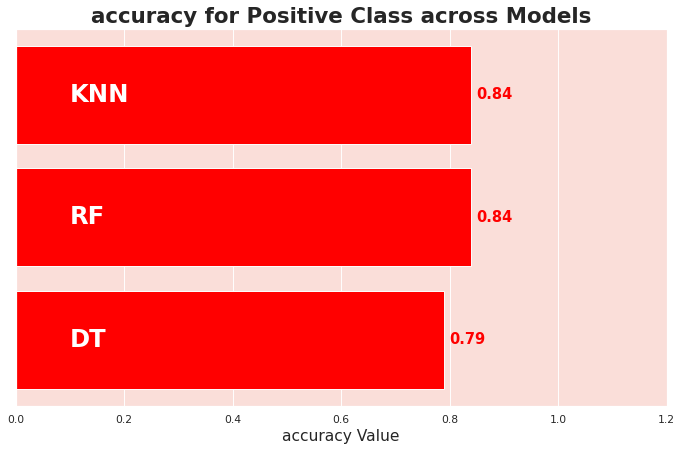

In [48]:
# Trier les valeurs en fonction de 'accuracy'
results.sort_values(by='accuracy', ascending=True, inplace=True)
recall_1_scores = results['accuracy']

# Tracer le diagramme à barres horizontal
fig, ax = plt.subplots(figsize=(12, 7), dpi=70)
ax.barh(results.index, recall_1_scores, color='red')

# Annoter les valeurs et les index
for i, (value, name) in enumerate(zip(recall_1_scores, results.index)):
    ax.text(value + 0.01, i, f"{value:.2f}", ha='left', va='center', fontweight='bold', color='red', fontsize=15)
    ax.text(0.1, i, name, ha='left', va='center', fontweight='bold', color='white', fontsize=25)

# Supprimer les graduations de l'axe y
ax.set_yticks([])

# Définir la limite de l'axe des x
ax.set_xlim([0, 1.2])

# Ajouter un titre et une étiquette d'axe x
plt.title("accuracy for Positive Class across Models", fontweight='bold', fontsize=22)
plt.xlabel('accuracy Value', fontsize=16)
plt.show()

Le modèle de forêt et KNN aléatoire démontre une capacité louable à reconnaître les patients potentiels atteints de maladie cardiaque. Avec un rappel de 0,84 pour la classe 1, il est évident que presque tous les patients atteints de maladie cardiaque sont correctement identifiés. Cela revêt une importance primordiale dans un contexte médical. Cependant, la performance équilibrée du modèle garantit que tout en visant un rappel élevé, il ne compromet pas la précision, ne surchargeant donc pas le système avec des alertes inutiles.